#exploring on SemCor and Brown Corpus
In this notebook, we will investigate the list of adjectives in both corpora regarding senses and shared tags.  

In [ ]:
#import packages
from nltk.corpus import wordnet
from nltk.corpus import semcor
from nltk.corpus import brown
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import semcor
from nltk.corpus import wordnet as wn 
from nltk.corpus.reader.wordnet import Lemma
from nltk.corpus.reader.wordnet import Synset
from re import sub
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import pickle
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.__version__

'3.7'

## SemCor

In [ ]:
#semcor setup
nltk.download('semcor')
semcor_words = semcor.words()
# len(semcor_words) #820411
semcor_chunks = semcor.chunks()
# len(semcor_chunks) #778587
semcor_sents = semcor.sents()
# len(semcor_sent) #37176
myword = 'present'

[nltk_data] Downloading package semcor to /root/nltk_data...


In [ ]:
#cerate the list of adjectives with sense and POS taggs.
cnt = 0
ban_char = [' ', '-']
semcor_adj_idx_sns_dict = dict()
sense_adj_dict = dict()
for chunk in semcor.tagged_chunks(tag=("both")):
  #check if POS is 'JJ'
  if 'JJ' in str(chunk):
    idx_start = str(chunk).replace("'","").find('JJ')
    idx_end = str(chunk).replace("'","").find(')', idx_start)
    
    if any(ch in str(chunk)[idx_start+3: idx_end] for ch in ban_char) or \
    any(chr.isdigit() for chr in str(chunk)[idx_start+3: idx_end]):
      pass
    else:
      adj = str(chunk)[idx_start+3: idx_end].lower()
      if str(chunk)[idx_start-3].isdigit() and str(chunk)[idx_start-4].isdigit():
        adj_sense = str(chunk)[idx_start-6: idx_start-2].lower()

      else:
        adj_sense = ''
    #remove non-sense words which are not adj  
      if len(adj) > 2 and len(adj_sense) > 1:
        semcor_adj_idx_sns_dict[cnt] = (adj, adj_sense)
        adj_sense_format = adj_sense + ', '
        if adj in sense_adj_dict.keys():
          sense_adj_dict[adj] += adj_sense_format
        else:
          sense_adj_dict[adj] = adj_sense_format

    cnt += 1

In [ ]:
sense_set_adj_dict = dict()
for ky, vlu in sense_adj_dict.items():
  vlu_format = vlu.split(', ')
  vlu_format.remove('')
  sense_set_adj_dict[ky] = set(vlu_format)

In [ ]:
#check the sense types of a word
myword_list = []
for val in semcor_adj_idx_sns_dict.values():
  if myword in val:
    myword_list.append(val[1])

print(set(myword_list))

{'a.01', 'a.02'}


In [ ]:
len(semcor_adj_idx_sns_dict)

32755

In [ ]:
semcor_adj_idx_sns_df = pd.DataFrame.from_dict(semcor_adj_idx_sns_dict).T
semcor_adj_idx_sns_df.rename(columns={0: "adjective", 1: "sense"}, inplace=True)

In [ ]:
semcor_adj_idx_sns_df.shape[0]

32755

In [ ]:
semcor_adj_idx_sns_df[semcor_adj_idx_sns_df['adjective'] == myword].head()
set_adj_types = set(semcor_adj_idx_sns_df['adjective'])

In [ ]:
# how many sense for each adjective
semcor_adj_idx_sns_freq = semcor_adj_idx_sns_df.groupby(["adjective", "sense"]).size()

In [ ]:
Nr_adjectives = semcor_adj_idx_sns_df.groupby(["adjective"]).count().count()[0]
df_tokens = semcor_adj_idx_sns_df.groupby(["adjective"]).count()

In [ ]:
#how many adjective semcor has for each sense!
semcor_sns_idx_adj_freq = semcor_adj_idx_sns_df.groupby(["sense", "adjective"]).size()

In [ ]:
semcor_adj_idx_sns_freq[myword]

sense
a.01    55
a.02    39
dtype: int64

In [ ]:
semcor_adj_idx_sns_freq[myword].sum()

94

In [ ]:
#list of words with a specific sense
semcor_sns_idx_adj_freq['s.00'].head()

adjective
abandoned       1
abstract        1
abstracted      2
accelerated     2
accelerating    2
dtype: int64

In [ ]:
semcor_sns_idx_adj_freq = pd.DataFrame(semcor_sns_idx_adj_freq, columns=['token frequency'])
semcor_adj_idx_sns_freq = pd.DataFrame(semcor_adj_idx_sns_freq, columns=['Nr. adj_senses'])

In [ ]:
semcor_adj_idx_sns_freq.head(20)

Nr. adj_senses
adjective   sense                
abandoned   s.00                1
            s.01                1
abbreviated s.01                1
abdominal   a.01                3
aberrant    s.01                1
abhorrent   s.01                1
abiding     s.01                2
abject      s.01                1
ablated     s.01                1
ablaze      s.01                1
able        a.01               67
            s.02                6
            s.03                4
abler       a.01                1
abnormal    a.01                1
abounding   s.01                1
above       s.01               13
aboveground s.01                1
abroad      s.01                6
abrupt      s.01                2

In [ ]:
semcor_adj_idx_sns_freq.iloc[2]

Nr. adj_senses    1
Name: (abbreviated, s.01), dtype: int64

In [ ]:
for i in semcor_adj_idx_sns_freq.index:
  print(i)
  break

('abandoned', 's.00')


In [ ]:
current_word = ''
prob_list = []
entropy_list = np.zeros(Nr_adjectives)
adjective_list = []
cnt = 0
for w in semcor_adj_idx_sns_freq.iterrows():
  if w[0][0] != current_word or cnt==Nr_adjectives-2: #the word is changed
    if len(prob_list) > 0:
      entropy_list[cnt] = scipy.stats.entropy(prob_list)
      adjective_list.append(current_word)
      cnt += 1
    current_word = w[0][0]
    prob_list = []
  prob_list.append(w[1][0])

In [ ]:
adjective_entrpy_list = pd.DataFrame(adjective_list, columns=['adjective'])
adjective_entrpy_list['adj_entropy'] = entropy_list

In [ ]:
adjective_entrpy_list = pd.merge(adjective_entrpy_list, df_tokens, on ='adjective')

<Figure size 1800x1200 with 0 Axes>

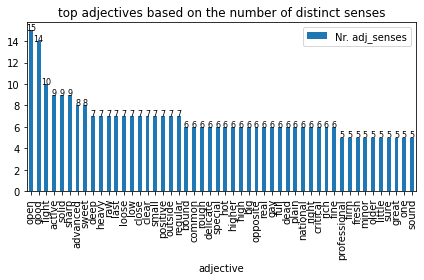

In [ ]:
#top adjective with the highest frequent senses
plt.figure(dpi=300)
semcor_adj_sns_top_freq = semcor_adj_idx_sns_freq.groupby('adjective').count()
semcor_adj_sns_top_freq.sort_values(by='Nr. adj_senses', inplace=True, ascending=False)
semcor_adj_sns_top_freq.iloc[:50].plot.bar(title='top adjectives based on the number of distinct senses');
for i in range(50):
  plt.text(i,
           semcor_adj_sns_top_freq.loc[:, 'Nr. adj_senses'][i],
           semcor_adj_sns_top_freq.loc[:, 'Nr. adj_senses'][i],
           ha='center', fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
adjective_entrpy_list = pd.merge(adjective_entrpy_list, semcor_adj_sns_top_freq, on ='adjective')

In [ ]:
adjective_entrpy_list.rename(columns={'adjective': 'adj_type', 'sense': 'token_freq'},
                             inplace=True)

In [ ]:
adjective_entrpy_list.to_excel('List of adj_entrpy.xlsx')

<Figure size 1800x1200 with 0 Axes>

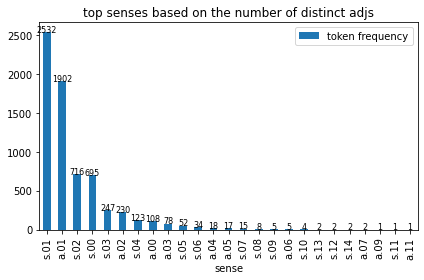

In [ ]:
#top senses with highest frequent adjectives
plt.figure(dpi=300)
semcor_sns_adj_top_freq = semcor_sns_idx_adj_freq.groupby('sense').count()
semcor_sns_adj_top_freq.sort_values(by='token frequency', inplace=True, ascending=False)
semcor_sns_adj_top_freq.iloc[:25].plot.bar(title='top senses based on the number of distinct adjs');
for i in range(25):
  plt.text(i,
           semcor_sns_adj_top_freq.loc[:, 'token frequency'][i],
           semcor_sns_adj_top_freq.loc[:, 'token frequency'][i],
           ha='center', fontsize=8)

plt.tight_layout()

In [ ]:
semcor_adj_freq = pd.DataFrame(semcor_adj_idx_sns_df.groupby(["adjective"]).size(),
                               columns=['token frequency'])
semcor_adj_freq.sort_values(by='token frequency', inplace=True, ascending=False)

In [ ]:
semcor_adj_sense = pd.merge(semcor_adj_sns_top_freq, 
                            semcor_adj_freq, on='adjective')

<Figure size 3000x1200 with 0 Axes>

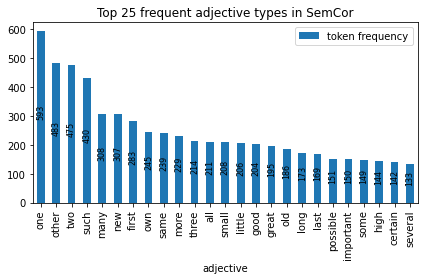

In [ ]:
#semcor adj sense bar chart
plt.figure(figsize=(10,4), dpi=300)
semcor_adj_freq.iloc[:25].plot.bar(title='Top 25 frequent adjective types in SemCor')
for i in range(25):
  plt.text(i,
           semcor_adj_freq.loc[:, 'token frequency'][i] // 2,
           semcor_adj_freq.loc[:, 'token frequency'][i],
           ha='center', rotation=90, fontsize=8)

plt.tight_layout()

## Brown

In [ ]:
nltk.download('brown')
# Brown methods
brown_words = brown.words()
# len(brown_words) #1161192
brown_tagged_words = brown.tagged_words()
# len(brown_tagged_words) #1161192
brown_sents = brown.sents()
# len(brown_sents) #57340
#categories
print(brown.categories())
#categorized access
brown.words(categories='news')

In [ ]:
from collections import defaultdict, Counter
word_tags = defaultdict(Counter)
for word, pos in brown.tagged_words():
    word_tags[word][pos] += 1

print(word_tags)

In [ ]:
word_tags['great']

In [ ]:
cnt = 0
brown_adj_idx_sns_dict = dict()
for chunk in brown.tagged_words():
  #check if POS is 'JJ'
  if 'JJ' in str(chunk):
    idx_start = str(chunk).replace("'","").find('JJ')
    idx_end = str(chunk).replace("'","").find(')', idx_start)
    adj = str(chunk)[idx_start+3: idx_end]
    if str(chunk)[idx_start-3].isdigit() and str(chunk)[idx_start-4].isdigit():
      adj_sense = str(chunk)[idx_start-6: idx_start-2].lower()
    else:
      adj_sense = ''
    #remove non-sense words which are not adj  
    if len(adj) > 2 and len(adj_sense) > 1:
      brown_adj_idx_sns_dict[cnt] = (adj, adj_sense)
  cnt += 1

In [ ]:
#exploring in Brown
news_text = brown.words(categories='news')
fdist = nltk.FreqDist(w.lower() for w in news_text)
modals = ['can', 'could', 'may', 'might', 'must', 'will']
for m in modals:
  print(m + ':', fdist[m], end=' ')

In [ ]:
cfd = nltk.ConditionalFreqDist((genre, word)
for genre in brown.categories()
for word in brown.words(categories=genre))
genres = ['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 
          'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']
adjs = ['great', 'small', 'big', 'high', 'large', 'tall', 'nice',
        'sweet', 'charming',  'delicious', 'awful']
cfd.tabulate(conditions=genres, samples=adjs, cumulative=False)

## WordNet


In [ ]:
#Wordnet download
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
#check an example
wn.synsets('great')

In [ ]:
wn.synset('great.n.01').definition()

In [ ]:
wn.synset('great.n.01').examples()

In [ ]:
wn.synset('great.s.02').lemmas()

In [ ]:
[str(lemma.name()) for lemma in wn.synset('great.s.02').lemmas()]

In [ ]:
great = wn.synset('great.n.01')

In [ ]:
great.hypernyms()

In [ ]:
great.hyponyms()

In [ ]:
syns = wordnet.synsets('great')
for s in syns:
    for l in s.lemmas():
        print(l.name() + " " + str(l.count()))